In [11]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


plots_colors = ['#009990', '#85A98F', '#5A6C57', '#525B44',  "#2A3335"]

In [12]:
# Loading...  game revieuws from google play store 
df = pd.read_csv("reviews.csv", delimiter=";")

print(f"Your dataset contains : {len(df['title'].unique())} games")
if df.duplicated().sum() == 0:
	print("no duplicates")
else:
	print(f"we deleting {df.duplicated().sum()} duplicates")
	df.drop_duplicates(inplace=True)

print(df.shape)

Your dataset contains : 374 games
we deleting 2 duplicates
(25384, 7)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25384 entries, 0 to 25385
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          25384 non-null  object 
 1   user_id        25384 non-null  object 
 2   date           25384 non-null  object 
 3   overall_score  25384 non-null  float64
 4   score          25384 non-null  int64  
 5   thumbsUp       25384 non-null  int64  
 6   text           25384 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ MB


In [14]:
df.head()

,title,user_id,date,overall_score,score,thumbsUp,text
0,Animal Crossing: Pocket Camp C,8e971efb-58ff-4cfb-a0e1-75f90671d96e,2024-12-07T21:19:38.976Z,4.39726,4,79,PLEASE BRING BACK THE SOCIAL ASPECTS!!! I love...
1,Animal Crossing: Pocket Camp C,0feef36c-a776-4b5b-8fe4-22eef5bb1a40,2024-12-05T20:31:54.341Z,4.39726,4,53,"Pretty good, but I wish there was more proper ..."
2,Animal Crossing: Pocket Camp C,a7660f0c-ed99-4c92-b69d-c85b6278950a,2024-12-05T03:50:47.652Z,4.39726,5,186,Better than the original! This version is bett...
3,Animal Crossing: Pocket Camp C,f7a89b9b-5809-40c0-bcb3-3019d296050a,2024-12-05T11:39:04.375Z,4.39726,5,155,I love it! No more micro transactions. I have ...
4,Animal Crossing: Pocket Camp C,a8cadc17-98f4-47c3-8ef8-82563870dd1c,2024-12-02T10:08:28.734Z,4.39726,5,287,"No microtransactions, better progression, offl..."


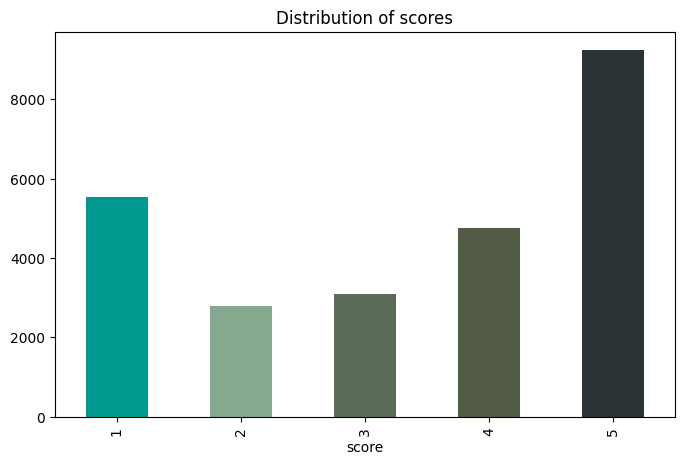

In [15]:
ax = df['score'].value_counts().sort_index().plot(kind='bar', title='Distribution of scores' , 
                                                  color=['#009990', '#85A98F', '#5A6C57', '#525B44',  "#2A3335"], figsize=(8, 5))

In [16]:
# Count bad and good reviews directly using boolean indexing
bad_count = (df['score'] < 3).sum()
good_count = (df['score'] >= 3).sum()

# Calculate percentages
bad_ratio = bad_count / len(df)
good_ratio = good_count / len(df)

# Print results
print(f"Bad reviews: {bad_ratio:.2%}")
print(f"Good reviews: {good_ratio:.2%}")


Bad reviews: 32.76%
Good reviews: 67.24%


In [17]:
example = df['text'][8]
print(example)

much improvement from the first, especially since you can get leaf tickets quickly now. would highly recommend if you enjoyed the first one! (first rating / review i think 😍)


In [18]:
nlp = spacy.load("en_core_web_lg")
example = nlp(example)
for token in example:
    print(token.text, token.pos_, token.tag_, token.is_stop)

much ADJ JJ True
improvement NOUN NN False
from ADP IN True
the DET DT True
first ADJ JJ True
, PUNCT , False
especially ADV RB False
since SCONJ IN True
you PRON PRP True
can AUX MD True
get VERB VB True
leaf NOUN NN False
tickets NOUN NNS False
quickly ADV RB False
now ADV RB True
. PUNCT . False
would AUX MD True
highly ADV RB False
recommend VERB VB False
if SCONJ IN True
you PRON PRP True
enjoyed VERB VBD False
the DET DT True
first ADJ JJ True
one NUM CD True
! PUNCT . False
( PUNCT -LRB- False
first ADJ JJ True
rating NOUN NN False
/ SYM SYM False
review NOUN NN False
i PRON PRP True
think VERB VBP False
😍 PROPN NNP False
) PUNCT -RRB- False


# Preprocessing:
**What can be done to improve the model?**
1. Handling Negations
2. Dealing with Misspellings and Slangs
3. Emoticons and Emojis: Convert them into sentiment indicators.

In [19]:
# Preprocessing : https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
# 1. lowercasing
# 2. remoce URL if exist
# 3. remoming digits
# 4. removing non-words and non-withespace (e.g emojis,!,?)==> means not Any Alphanumeric character and any white space [^\w\s]
# 5. removing any wors that have less than 3 characters  ===> means boundary of word of any word character that has 1 or 2 characters
# 6. removing stop word and Lemmatization
# 7. removing common words that are not useful in the context of the reviews like "play", 'game', 'time'

common_wods = {"play", 'game', 'time'} # from word cloud where these 3 words are the most common in all 3 sentiments thus not useful
nlp = spacy.load("en_core_web_lg")
def spacy_preprocessor(text):
    doc = nlp(text)
    # Lemmatize, lower text, and remove punctuation and stopwords
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and token.is_alpha and len(token.text) > 2 and token.text and token.text not in common_wods:
            token = tokens.append(token.lemma_.lower())
    return ' '.join(tokens)


In [20]:
tqdm.pandas(desc="Processing Text")
df['processed_text'] = df['text'].progress_apply(spacy_preprocessor)
print(df.isna().sum())

Processing Text: 100%|██████████| 25384/25384 [04:16<00:00, 99.06it/s] 

title             0
user_id           0
date              0
overall_score     0
score             0
thumbsUp          0
text              0
processed_text    0
dtype: int64


In [21]:
df.dropna(inplace=True)

### Sentiment Analysis:
- As we don't have sentiment collumn, but only score, we can see if model Like VADER or TextBlob validate the fact that score can be treated as sentiment !! if there is some correlation between score and sentiment.
- Vader use a bag of words approach, whereby it uses a dictionary to map words to sentiment values. It then calculates the sentiment of a sentence based on the sentiment values of the words in the sentence. each word is scored and combined to a total score.
- TextBlob uses a pattern-based approach, whereby it uses a pre-trained model to predict the sentiment of a sentence based on the words in the sentence. each word is scored and combined to a total score.



In [22]:
# Vader Sentiment Analysis
sia = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    res = sia.polarity_scores(text)
    return res['pos'], res['neg'], res['neu'], res['compound']

In [23]:
example = df.iloc[8]
print(example['text'])
# Vader example
print(sia.polarity_scores(example['processed_text']))
print(TextBlob(example['processed_text']).sentiment) # give polaritu [-1, 1] and subjectivity [0, 1], give a slightly positive vibe and is subjective at 68%

much improvement from the first, especially since you can get leaf tickets quickly now. would highly recommend if you enjoyed the first one! (first rating / review i think 😍)
{'neg': 0.0, 'neu': 0.463, 'pos': 0.537, 'compound': 0.8508}
Sentiment(polarity=0.18666666666666668, subjectivity=0.68)


In [26]:
#vader sentiment
pos_vader = []
neg_vader = []
neu_vader = []
compound_vader = []
for i, row in df.iterrows():
    pos, neg, neu, compound = vader_sentiment(row['processed_text'])
    pos_vader.append(pos)
    neg_vader.append(neg)
    neu_vader.append(neu)
    compound_vader.append(compound)
df['pos_vader'] = pos_vader
df['neg_vader'] = neg_vader
df['neu_vader'] = neu_vader
df['compound_vader'] = compound_vader
df.head()

,title,user_id,date,overall_score,score,thumbsUp,text,processed_text,pos_vader,neg_vader,neu_vader,compound_vader,polarity_tb,subjectivity_tb
0,Animal Crossing: Pocket Camp C,8e971efb-58ff-4cfb-a0e1-75f90671d96e,2024-12-07T21:19:38.976Z,4.39726,4,79,PLEASE BRING BACK THE SOCIAL ASPECTS!!! I love...,bring social aspects love interact player free...,0.603,0.043,0.354,0.9834,0.263333,0.551667
1,Animal Crossing: Pocket Camp C,0feef36c-a776-4b5b-8fe4-22eef5bb1a40,2024-12-05T20:31:54.341Z,4.39726,4,53,"Pretty good, but I wish there was more proper ...",pretty good wish proper gameplay sidequest sta...,0.246,0.031,0.724,0.8689,0.088782,0.544231
2,Animal Crossing: Pocket Camp C,a7660f0c-ed99-4c92-b69d-c85b6278950a,2024-12-05T03:50:47.652Z,4.39726,5,186,Better than the original! This version is bett...,well original version well way way easy item w...,0.483,0.109,0.408,0.9678,0.287058,0.707323
3,Animal Crossing: Pocket Camp C,f7a89b9b-5809-40c0-bcb3-3019d296050a,2024-12-05T11:39:04.375Z,4.39726,5,155,I love it! No more micro transactions. I have ...,love micro transaction access item extra cost ...,0.350,0.000,0.650,0.9081,0.300000,0.400000
4,Animal Crossing: Pocket Camp C,a8cadc17-98f4-47c3-8ef8-82563870dd1c,2024-12-02T10:08:28.734Z,4.39726,5,287,"No microtransactions, better progression, offl...",microtransaction well progression offline whis...,0.308,0.132,0.559,0.8781,0.193333,0.386154


In [27]:
#TextBlob sentiment
polarity_tb = []
subjectivity_tb = []
for i, row in df.iterrows():
    polarity, subjectivity = TextBlob(row['processed_text']).sentiment
    polarity_tb.append(polarity)
    subjectivity_tb.append(subjectivity)
df['polarity_tb'] = polarity_tb
df['subjectivity_tb'] = subjectivity_tb
df.head()

,title,user_id,date,overall_score,score,thumbsUp,text,processed_text,pos_vader,neg_vader,neu_vader,compound_vader,polarity_tb,subjectivity_tb
0,Animal Crossing: Pocket Camp C,8e971efb-58ff-4cfb-a0e1-75f90671d96e,2024-12-07T21:19:38.976Z,4.39726,4,79,PLEASE BRING BACK THE SOCIAL ASPECTS!!! I love...,bring social aspects love interact player free...,0.603,0.043,0.354,0.9834,0.263333,0.551667
1,Animal Crossing: Pocket Camp C,0feef36c-a776-4b5b-8fe4-22eef5bb1a40,2024-12-05T20:31:54.341Z,4.39726,4,53,"Pretty good, but I wish there was more proper ...",pretty good wish proper gameplay sidequest sta...,0.246,0.031,0.724,0.8689,0.088782,0.544231
2,Animal Crossing: Pocket Camp C,a7660f0c-ed99-4c92-b69d-c85b6278950a,2024-12-05T03:50:47.652Z,4.39726,5,186,Better than the original! This version is bett...,well original version well way way easy item w...,0.483,0.109,0.408,0.9678,0.287058,0.707323
3,Animal Crossing: Pocket Camp C,f7a89b9b-5809-40c0-bcb3-3019d296050a,2024-12-05T11:39:04.375Z,4.39726,5,155,I love it! No more micro transactions. I have ...,love micro transaction access item extra cost ...,0.350,0.000,0.650,0.9081,0.300000,0.400000
4,Animal Crossing: Pocket Camp C,a8cadc17-98f4-47c3-8ef8-82563870dd1c,2024-12-02T10:08:28.734Z,4.39726,5,287,"No microtransactions, better progression, offl...",microtransaction well progression offline whis...,0.308,0.132,0.559,0.8781,0.193333,0.386154


/tmp/ipykernel_233839/1268089685.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = df, x='score', y='compound_vader', palette=plots_colors)


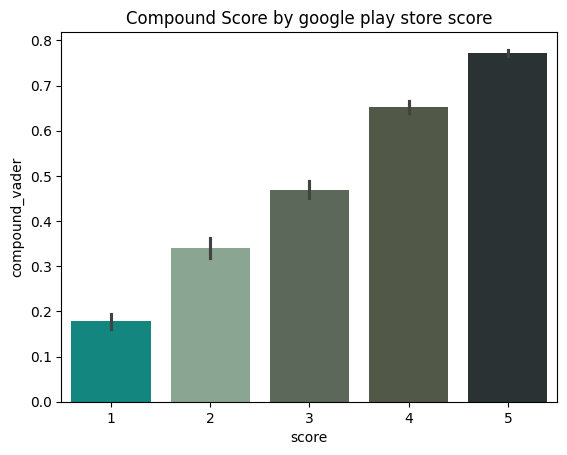

In [28]:
# https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook
ax = sns.barplot(data = df, x='score', y='compound_vader', palette=plots_colors)
ax.set_title('Compound Score by google play store score')
plt.show()

/tmp/ipykernel_233839/1635029480.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x='score', y='pos_vader', palette=plots_colors, ax=axs[0])
/tmp/ipykernel_233839/1635029480.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x='score', y='neu_vader', palette=plots_colors, ax=axs[2])
/tmp/ipykernel_233839/1635029480.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x='score', y='neg_vader', palette=plots_colors, ax=axs[1])
/tmp/ipykernel_233839/1635029480.py:5: FutureWarning: 

Passing `palette` without 

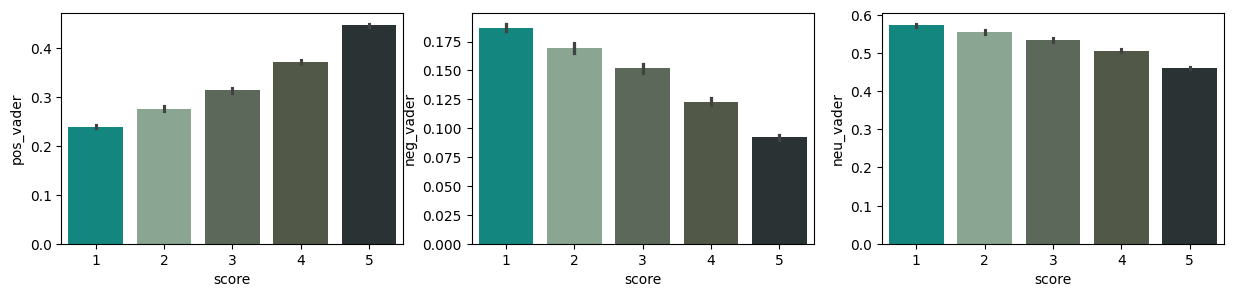

In [29]:
figs, axs = plt.subplots(1, 3, figsize=(15, 3))
sns.barplot(data = df, x='score', y='pos_vader', palette=plots_colors, ax=axs[0])
sns.barplot(data = df, x='score', y='neu_vader', palette=plots_colors, ax=axs[2])
sns.barplot(data = df, x='score', y='neg_vader', palette=plots_colors, ax=axs[1])
sns.barplot(data = df, x='score', y='neg_vader', palette=plots_colors, ax=axs[1])
plt.show()

In [50]:
# sarcasm detection test
sarc_txt  = "Wow, this game is an absolute masterpiece! I mean, who doesn’t love constant crashes and loading screens longer than the actual gameplay? The controls are so intuitive—especially when they randomly stop working in the middle of a boss fight. And let’s not forget the in-app purchases! Paying $10 just to unlock a new outfit really makes me feel like I’m part of an exclusive club of overly generous players. Thank you, developers, for reminding me that patience truly is a virtue. 5 stars... if I could ever get past the loading screen."
print(sia.polarity_scores(sarc_txt))
sarc_txt_2 = "1.6 is finally here. Thank you ConcernedApe! My only issue is that I can'y seem to upgrade the kitchen room since there's a decor on the wall which I placed when I still played the game from PC. I transferred my saved file to Android and I can't seem to find any of the controllers that can pick out the said plant wall decor. I hope we'll get the option soon so that I can upgrade my kitchen."
print(sia.polarity_scores(sarc_txt_2))

{'neg': 0.042, 'neu': 0.698, 'pos': 0.26, 'compound': 0.9752}
{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'compound': 0.8718}


/tmp/ipykernel_233839/1876097896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x='score', y='polarity_tb', palette=plots_colors, ax=axs[0])
/tmp/ipykernel_233839/1876097896.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x='score', y='subjectivity_tb', palette=plots_colors, ax=axs[1])
/tmp/ipykernel_233839/1876097896.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[2, 2, 1, 0.5])


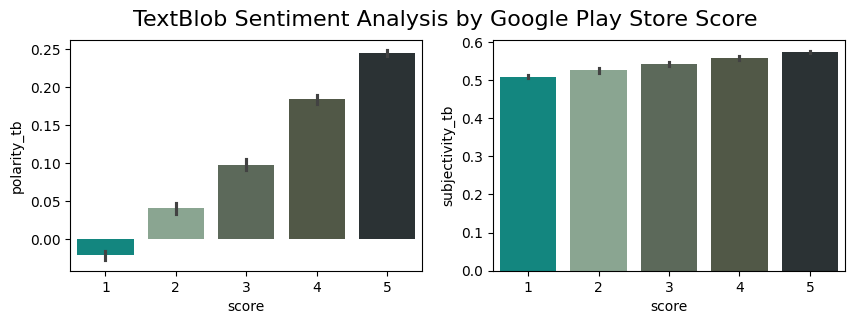

In [37]:
figs, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.barplot(data = df, x='score', y='polarity_tb', palette=plots_colors, ax=axs[0])
sns.barplot(data = df, x='score', y='subjectivity_tb', palette=plots_colors, ax=axs[1])
figs.suptitle('TextBlob Sentiment Analysis by Google Play Store Score', fontsize=16)
plt.tight_layout(rect=[2, 2, 1, 0.5])
plt.show()


In [ ]:
# People tend to be subjective but generally lean towards positive reviews. Therefore, a 3-star rating should be considered more positive than negative.

In [39]:
sentiment_stars_based = []
for i, row in df.iterrows():
    if row['score'] >= 3:
        sentiment_stars_based.append("positive")
    else:
        sentiment_stars_based.append("negative")
df['sentiment_stars_based'] = sentiment_stars_based

We can clearly see a tendency of text sentiment with the score. Higher the score, more positive the sentiment.
- DO MORE ANALYSIS ON THIS !!, but very interesting to see that score gives you somehow a sentiment of the text.

In [40]:
# what could be interesting to see is highest pos/neg in the lowest score and vice versa

# Vader
query_1 = df[df['score']==1].sort_values('pos_vader', ascending=False).iloc[0]
print(f"title : {query_1['title']}, txt : {query_1['text']}, score :{query_1['score']}") # here it is sarcastic review or missmatch the rating, the text is small to not catch the sarcasm or not
query_2 = df[df['score']==5].sort_values('neg_vader', ascending=False).iloc[0]
print(f"title : {query_2['title']}, txt : {query_2['text']}, score :{query_2['score']}") # Here catch that a user is negative and maybe he is not right in his stars rating

# TextBlob
# lowest score with highest polarity
query_1 = df[df['score']==1].sort_values('polarity_tb', ascending=False).iloc[0]
print(f"title : {query_1['title']}, txt : {query_1['text']}, score :{query_1['score']}, polarity : {query_1['polarity_tb']}") # TextBlob doesn't catch the meaning as it works as a bag of words
query_2 = df[df['score']==5].sort_values('polarity_tb', ascending=True).iloc[0]
# highest score with lowest polarity
print(f"title : {query_2['title']}, txt : {query_2['text']}, score :{query_2['score']}, polarity : {query_1['polarity_tb']}") # Catch very well the meaning


title : DOP Delete Stories: Erase Game, txt : It is a really fun game, score :1
title : Balatro, txt : Can't stop, score :5
title : EvoCreo - Pocket Monster Game, txt : I just bought this game only about 5 minutes ago, its already crashed twice. Once while just giving myself a name in the game and again just walking around at the very beginning. This game looked awesome and the reviews looked great. But i cant even play it! Now the game wont even let me save and I completly lost all of the gems I paid for and all of the levels I grew on my creo, score :1, polarity : 0.9
title : Geometry Dash, txt : Playing this since 2015 and never thought this was going to be the game where I would entertain myself for years. This is not just a jumping cube avoiding spikes game, this is where you see unimaginable levels the community does almost every day, with the insane infinity of things that can be done in the level editor. Even also a multiplatform game, you have almost everything you need in the

Vader appears to outperform TextBlob, although it is not without its limitations. 
- One noticeable drawback is that Vader struggles to detect sarcasm.
- Good at detecting negation, but sarcasm still is a problem.


> We will use Vader model and Score to get the sentiment of the text. We will create a hybrid score where we will combine Vader and score together and if the score is 
higher than 0 than the sentiment tends to be positive and when the < 0 then to be negative this calculation with weith adjustment can counter sarcasm

In [66]:
# example 
query_1 = df[df['score']==1].sort_values('pos_vader', ascending=False).iloc[0]
print(f"title : {query_1['title']}, txt : {query_1['text']}, stars: {query_1['score']}, score :{query_1['pos_vader']}") # here it is sarcastic review 

# 60% weight goes to Vader and 40% score
#[-1,1]
norm_score = query_1['score'] - 3/2
hybrid_score = query_1['compound_vader']*0.6 + norm_score*0.4
hybrid_score # still having a positive score but at least we manged to reduce it as we know tht some of the reviews are sarcastic and we can't rely solely on the text

title : DOP Delete Stories: Erase Game, txt : It is a really fun game, stars: 1, score :1.0


np.float64(0.10636000000000001)

# Normalized Score
- Formula  = (SCORE - 3)/2 , will give a score between -1 and 1 where -1 means strongly negative and 1 strongly positive.

> Using the hybrid score formula (0.2 * compound_vader + 0.8 * norm_score), where norm_score is the normalized review score scaled to [-1, 1], we classify the sentiment:

- If hybrid_score > 0, the sentiment is positive.
- Otherwise, the sentiment is negative.

> We will still have some text that are sentimentaly sarcastic and labelled as positive; but at least, we reduce the negative effect of sarcasm.

In [67]:
def normalize_score(score):
    return (score - 3)/2

def hybrid_score(row, weight_vader=0.2):
    sentiment = []
    for i, row in df.iterrows():
        compound_vader = row['compound_vader']
        normalized_score = normalize_score(row['score'])
        sentiment.append(compound_vader*weight_vader + normalized_score*(1-weight_vader))
    return sentiment
df['hybrid_score'] = hybrid_score(df)   

In [ ]:
# Vader
# best hybrid score for the lowest score
query_1 = df[df['score']==1].sort_values('hybrid_score', ascending=False).iloc[0]
print("title ", query_1['title'])
pprint.pprint(query_1['text'])
print("stars ", query_1['score'])
print("hybrid_score ", query_1['hybrid_score']) # he is positive about the game but mention some negative points, the score must be lower than Vader gave

# least hybrid score for the highest score
query_1 = df[df['score']==5].sort_values('hybrid_score', ascending=True).iloc[0]
print("title ", query_1['title'])
pprint.pprint(query_1['text'])
print("stars ", query_1['score'])
print("hybrid_score ", query_1['hybrid_score']) # still this game review has negative sentiment eventhough the user gave it 5 stars. 
                                                # The only explanation would be that he mislead the rating or sarcasm


title  Subway Surfers
('Why do we have to see ads in order to gain our rewards in the daily events, '
 'we achieved the wanted goal so why ads to collect our rewards. There was a '
 'time when I was able to collect my awards free of ads  why did that change. '
 'Have this flaw fixed ASAP because it deals a great value of points to the '
 'total count of the event coins and tokens within the game. Other than that, '
 'a great yet wonderful game to play and spend free time.')
stars  1
hybrid_score  -0.6023200000000001
title  My Talking Tom 2
('This is game This game is horrible. It is a horrible. Very very a horrible. '
 'My daughter Emilia wanted downloaded the it the her iPhone and she me ask '
 'and I say sure, my child. But alas, when I returned she was had been a the '
 'died. This game is a very cursed, and is bad. And It will haunt, ruin, and '
 'brain.')
stars  5
hybrid_score  0.6037600000000001


> Now we have a good scoring based on the text but also based on the stars. some revieuw doesn't match with stars, but I managed with weight lower the score so that some revieuws that are considered as sarcasm could posibly be negative or positive, because Vader use bag of word system and does not rely on a sense of the text.


In [69]:
sentiment = []
for i, row in df.iterrows():
    if row['hybrid_score'] >= 0:
        sentiment.append('positive')
    else:
        sentiment.append('negative')
df['sentiment'] = sentiment
df.head()

,title,user_id,date,overall_score,score,thumbsUp,text,processed_text,pos_vader,neg_vader,neu_vader,compound_vader,polarity_tb,subjectivity_tb,hybrid_score,sentiment,sentiment_stars_based
0,Animal Crossing: Pocket Camp C,8e971efb-58ff-4cfb-a0e1-75f90671d96e,2024-12-07T21:19:38.976Z,4.39726,4,79,PLEASE BRING BACK THE SOCIAL ASPECTS!!! I love...,bring social aspects love interact player free...,0.603,0.043,0.354,0.9834,0.263333,0.551667,0.59668,positive,positive
1,Animal Crossing: Pocket Camp C,0feef36c-a776-4b5b-8fe4-22eef5bb1a40,2024-12-05T20:31:54.341Z,4.39726,4,53,"Pretty good, but I wish there was more proper ...",pretty good wish proper gameplay sidequest sta...,0.246,0.031,0.724,0.8689,0.088782,0.544231,0.57378,positive,positive
2,Animal Crossing: Pocket Camp C,a7660f0c-ed99-4c92-b69d-c85b6278950a,2024-12-05T03:50:47.652Z,4.39726,5,186,Better than the original! This version is bett...,well original version well way way easy item w...,0.483,0.109,0.408,0.9678,0.287058,0.707323,0.99356,positive,positive
3,Animal Crossing: Pocket Camp C,f7a89b9b-5809-40c0-bcb3-3019d296050a,2024-12-05T11:39:04.375Z,4.39726,5,155,I love it! No more micro transactions. I have ...,love micro transaction access item extra cost ...,0.350,0.000,0.650,0.9081,0.300000,0.400000,0.98162,positive,positive
4,Animal Crossing: Pocket Camp C,a8cadc17-98f4-47c3-8ef8-82563870dd1c,2024-12-02T10:08:28.734Z,4.39726,5,287,"No microtransactions, better progression, offl...",microtransaction well progression offline whis...,0.308,0.132,0.559,0.8781,0.193333,0.386154,0.97562,positive,positive


0.9751812165143398
Title : Total Battle: Tactical Wars, text : This is NOT a puzzle game. Puzzle is only a side game. The main game is building and grinding game. Good concept, but only has 1 builder to build and upgrade. Not enough intro game play to guide new user. It is not a game that can be fun for solo play. You need to join clan. And new solo players get attack too much with no protection. Especially fighting resources, higher level players can attack you and you lose all the effort to mine or collect. Overall, average at best for gameplay., stars : 3, sentiment : positive, hybrid : negative
Title : Pick Me Up 3D: Taxi Game, text : At first the game was fine except the ads it was a lil to mang but im fine wit that my problem is that im now at level 96 and i now i cant play the game at all like i can go in to the game but when i tap my phone tje game doesnt start idk if it stops at 96 but im really confused plz fix the bug or add more levels whatever the problem maybe i just ask 

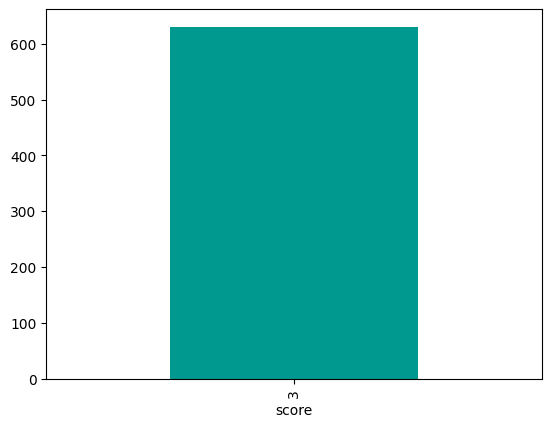

In [122]:
# Compare the hybrid and the stars based sentiment
print(accuracy_score(df['sentiment'], df['sentiment_stars_based'])) # 97% of the time the hybrid sentiment is the same as the stars based sentiment

# Analyse some text that are different in sentiment
diff_text  = df[df['sentiment'] != df['sentiment_stars_based']].sample(5)
for i, row in diff_text.iterrows():
    print(f"Title : {row['title']}, text : {row['text']}, stars : {row['score']}, sentiment : {row['sentiment_stars_based']}, hybrid : {row['sentiment']}") 

# Here the hybrid Method is much more accurate than the stars based sentiment because as I said 3 stars are very subjective and the user can be positive or negative but here we can see
# that all sampled text are written in negative way but the number of stars is 3 => hybrid classified it as negative which is good.
pos_3_senti = df[(df['score'] == 3) & (df['sentiment'] == 'positive')]["sentiment"].count()
print(pos_3_senti)
neg_3_senti = df[(df['score'] == 3) & (df['sentiment'] == 'negative')]["sentiment"].count()
print(f"There are {pos_3_senti} positive sentiment with 3 stars ({round(pos_3_senti/(pos_3_senti+neg_3_senti)*100,2)}%) and {neg_3_senti} negative sentiment with 3 stars ({round(neg_3_senti/(pos_3_senti+neg_3_senti)*100,2)}%)")

# what scores are the most different btw sentiment and stars based sentiment
diff_scores = df[df['sentiment'] != df['sentiment_stars_based']]['score'].value_counts()
diff_scores.plot(kind='bar', color=plots_colors)
print(f"only {round(diff_scores.sum()/len(df)*100,2)}% of all revieuws are missclassified")
# only revieuws with 3 stars are the one who are missclassified which seems to be normal as 3 stars are very subjective and dont know if it is positive nor negative, and I classified them as positive.

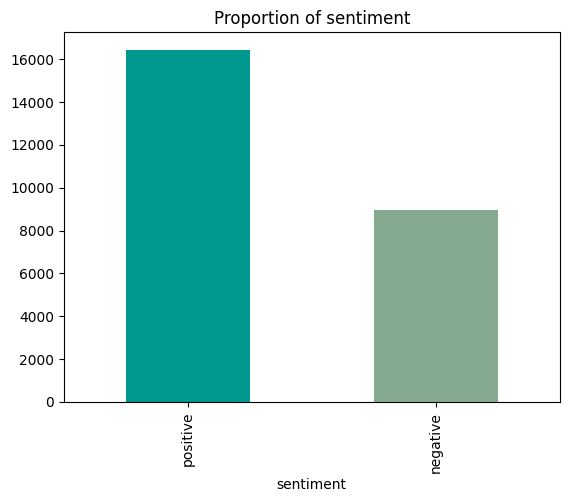

positive sentiment: 64.76 %
negative sentiment: 35.24 %


In [123]:
count_class = df['sentiment'].value_counts()
count_class.plot(kind='bar', color=['#009990', '#85A98F'])
plt.title('Proportion of sentiment')
plt.show()

print('positive sentiment:', round(count_class['positive']/df.shape[0]*100,2),"%")
print('negative sentiment:', round(count_class['negative']/df.shape[0]*100,2),"%")
# 76% of reviews are positive and only 24% are negative, which means that games are well received by the users
# But in Machine learning means that we have an imbalanced dataset- > undersampling (applying random min sampling) or oversampling (SMOTE)

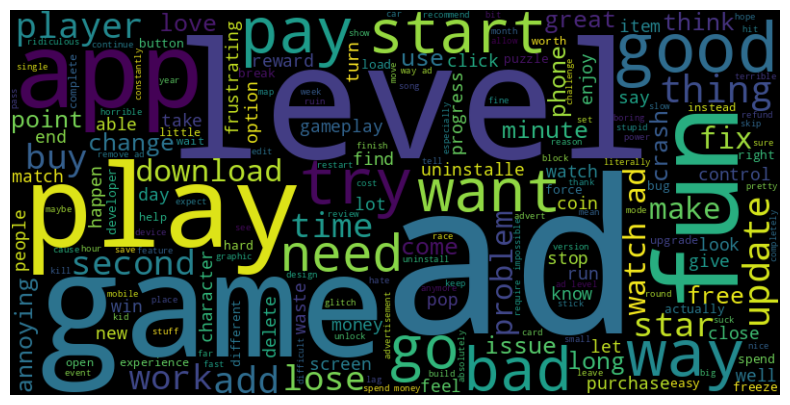

In [124]:
# Most common words in negative reviews
plt.figure(figsize=(10, 5))
wc = WordCloud(width=800, height=400, max_words=200).generate(' '.join(df[df['sentiment']=='negative']['processed_text']))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

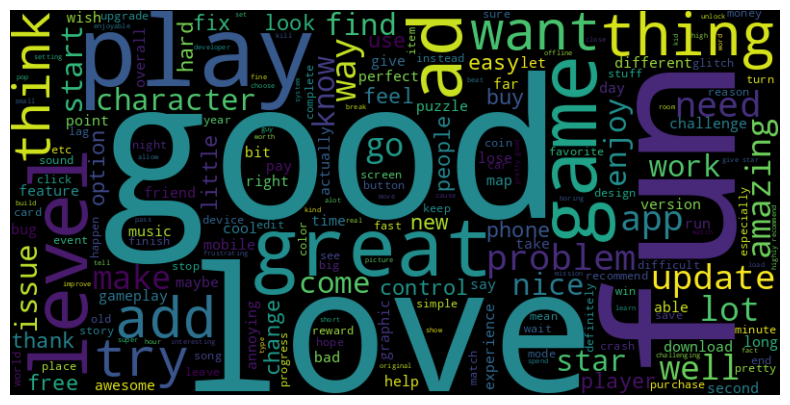

In [125]:
# Most common words in negative reviews
plt.figure(figsize=(10, 5))
wc = WordCloud(width=800, height=400, max_words=200).generate(' '.join(df[df['sentiment']=='positive']['processed_text']))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

# Naive Bayes

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.25, random_state=42)

In [ ]:
dummy_clf = 7(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
dummy_clf.predict(X_test)
print("Accuracy by most frequent : ", dummy_clf.score(X_test,y_test))
################################
dummy_clf_2 = DummyClassifier(strategy="stratified")
dummy_clf_2.fit(X_train,y_train)
dummy_clf_2.predict(X_test)
print("Stratified accuracy: ",dummy_clf_2.score(X_test,y_test))

Accuracy by most frequent :  0.644500472738733
Stratified accuracy:  0.5439647021745981


In [127]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [128]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8269776236999685
              precision    recall  f1-score   support

    negative       0.74      0.79      0.76      2256
    positive       0.88      0.85      0.86      4090

    accuracy                           0.83      6346
   macro avg       0.81      0.82      0.81      6346
weighted avg       0.83      0.83      0.83      6346



In [129]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Oversampling but vector space in NLP is very high dimensional and SMOTE 
# https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification
# SMOTE works in feature space. It means that the output of SMOTE is not a synthetic data which is a real representative of a text inside its feature space.
# On one side SMOTE works with KNN and on the other hand, feature spaces for NLP problem are dramatically huge. KNN will easily fail in those huge dimensions.
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train)

# Train the model
model = MultinomialNB()
model.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
y_pred = model.predict(X_test_vec)
print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
print(classification_report(y_test, y_pred))

/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Accuracy: 0.818
              precision    recall  f1-score   support

    negative       0.73      0.78      0.75      2710
    positive       0.87      0.84      0.86      4906

    accuracy                           0.82      7616
   macro avg       0.80      0.81      0.80      7616
weighted avg       0.82      0.82      0.82      7616



In [130]:
# unbalanced Data => undersampling
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.25, random_state=42)

min_class_size = df['sentiment'].value_counts().min()
balanced_training_data = df.groupby('sentiment').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

X_train = balanced_training_data['text']
y_train = balanced_training_data['sentiment']

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/tmp/ipykernel_484610/1724046083.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_training_data = df.groupby('sentiment').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


Accuracy: 0.848408446265364
              precision    recall  f1-score   support

    negative       0.74      0.89      0.81      2256
    positive       0.93      0.82      0.88      4090

    accuracy                           0.85      6346
   macro avg       0.83      0.86      0.84      6346
weighted avg       0.86      0.85      0.85      6346



In [99]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.25, random_state=42)

model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)],
    'vectorizer__max_df': [0.7, 0.8, 0.9],
    'vectorizer__binary': [True, False],
    'classifier__alpha': [0.1, 0.5, 1]
}

search = GridSearchCV(model, param_grid, cv=5, verbose=3, scoring='f1')
search.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.2s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.2s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.8s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   1.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   1.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.8s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   1.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   1.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.2s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   1.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=0.5, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=True, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.7, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.8, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.5s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 1);, score=nan total time=   0.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 2);, score=nan total time=   2.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.1s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   5.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(1, 3);, score=nan total time=   4.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.7s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(2, 2);, score=nan total time=   1.6s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 1/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 2/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 3/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   3.0s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 4/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/klinovsky/SEB_FOLDER/UCL_informatique/MASTER_2/Q1/Text Mining/project/env_project/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV 5/5] END classifier__alpha=1, vectorizer__binary=False, vectorizer__max_df=0.9, vectorizer__ngram_range=(3, 3);, score=nan total time=   2.9s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.1, 0.5, 1],
                         'vectorizer__binary': [True, False],
                         'vectorizer__max_df': [0.7, 0.8, 0.9],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                     (2, 2), (3, 3)]},
             scoring='f1', verbose=3)

In [102]:
print(search.best_params_)

{'classifier__alpha': 0.1, 'vectorizer__binary': True, 'vectorizer__max_df': 0.7, 'vectorizer__ngram_range': (1, 1)}


In [133]:
# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.20, random_state=42) # 20% test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 60% train, 20% validation

# Undersampling
min_class_size = y_train.value_counts().min()
balanced_training_data = (
    pd.DataFrame({'text': X_train, 'sentiment': y_train})
    .groupby('sentiment')
    .apply(lambda x: x.sample(min_class_size))
    .reset_index(drop=True)
)
X_train = balanced_training_data['text']
y_train = balanced_training_data['sentiment']

# Modelling
vectorizer = CountVectorizer(binary=True, max_df=0.7, ngram_range=(1,1))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)
model = MultinomialNB(alpha=1)

# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_vec, y_train)):
    X_cv_train, X_cv_val = X_train_vec[train_idx], X_train_vec[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_cv_train, y_cv_train)
    y_cv_pred = model.predict(X_cv_val)
    accuracy = accuracy_score(y_cv_val, y_cv_pred)
    accuracy_scores.append(accuracy)
print("Train accuracy:", accuracy_score(y_train, model.predict(X_train_vec)))
print(f"Mean CV Accuracy: {np.mean(accuracy_scores)}")
   
# Test the underspampled tuned Model on test set
model.fit(X_train_vec, y_train)
y_test_pred = model.predict(X_test_vec)
print("Final Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

/tmp/ipykernel_484610/980974836.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_class_size))


Train accuracy: 0.873761913660998
Mean CV Accuracy: 0.8174159162239671
Final Test Accuracy: 0.812881623005712
              precision    recall  f1-score   support

    negative       0.69      0.85      0.77      1818
    positive       0.91      0.79      0.84      3259

    accuracy                           0.81      5077
   macro avg       0.80      0.82      0.80      5077
weighted avg       0.83      0.81      0.82      5077



- Model doesn't appear to overfit, we consider overfitting when large gap btw train and test set eg. > 10%
- For negative precision is at 69%, due to unbalanced data the model still predict lot of negative but infact were positives ==> false positive
- Positive Recall is at 79% not bad, identifies most of positive but some are missed.

- Accuracy (80%): 81% of predictions are correct.
- Macro Avg: Highlights slight imbalance in performance between classes (favoring positive).
- Weighted Avg: Reflects class distribution; strong overall performance due to positive dominance.


### Overall the model seems to predict very well the sentiment based on the text

# Let's Play With Our Model for a Bit

In [ ]:
# Positive
rewiew_1 = spacy_preprocessor("Quite nice.. no forced microtransactions, nor annoying mechanics.. tbh one of the better clicker games.. Perhaps could include more adventure-type gameplay, and more mini-games.")
print(model.predict(vectorizer.transform([rewiew_1]))[0])
# Negative
rewiew_2 = spacy_preprocessor("Amusing game with a unique style. However, it has a problem. If you use a VPN that connects through Europe, it will not recognize the connection, thus denying you the bonuses that are available by playing ads. There is no effective work-around (I really tried). Since the game is free, this flaw would seem to be rather self-defeating from the dev's perspective. Update: Now the problem is worse, affecting the game no matter how the connection is routed. Does Bethesda NOT want ad revenue? Weird.")
print(model.predict(vectorizer.transform([rewiew_2]))[0])
# Negative
rewiew_3 = spacy_preprocessor("This game is money hungry I worked so hard. To get all the accessories and stuff now it's, asking me to pay for it and all budge games do this and it's annoying.")
print(model.predict(vectorizer.transform([rewiew_3]))[0])
# something Hard to predict Neutral but tends to be positive...
rewiew_4 = spacy_preprocessor("i don't why i can't design someone anymore it only said join for more and when i click it i had to pay for something ? , totally good i love it but i can only freestyle now and not get any gifts")
print(model.predict(vectorizer.transform([rewiew_4]))[0]) # this review is either positive or negative, it is hard to predict,
                                                       # as we can see from the scores model tends to predict more positive reviews than negative ones

# Overall the model seems to be working well !!!

positive
negative
negative
positive
